## Geneformer Fine-Tuning for Classification of Dosage-Sensitive vs. -Insensitive Transcription Factors (TFs)

In [6]:
import os
GPU_NUMBER = [0]
os.environ["CUDA_VISIBLE_DEVICES"] = "" #",".join([str(s) for s in GPU_NUMBER])
os.environ["NCCL_DEBUG"] = "INFO"

In [7]:
import sys
sys.path.append("..")

In [9]:
# imports
import datetime
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_from_disk
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import StratifiedKFold
import torch
from transformers import BertModel
from transformers import Trainer
from transformers.training_args import TrainingArguments
from tqdm.notebook import tqdm

from geneformer import DataCollatorForGeneClassification
from geneformer.pretrainer import token_dictionary

## Load Gene Attribute Information

In [4]:
from genepy.utils import helper as h 

In [5]:
# autoreload
%load_ext autoreload
%autoreload 2

In [6]:
gene_info = h.getBiomartTable(
    ensemble_server="http://jul2023.archive.ensembl.org/biomart",
    useCache=True,
    attributes=[]
)

# table of corresponding Ensembl IDs, gene names, and gene types (e.g. coding, miRNA, etc.)

# create dictionaries for corresponding attributes
gene_id_type_dict = dict(zip(gene_info["ensembl_gene_id"],gene_info["gene_biotype"]))
gene_name_id_dict = dict(zip(gene_info["hgnc_symbol"],gene_info["ensembl_gene_id"]))
gene_id_name_dict = {v: k for k,v in gene_name_id_dict.items()}

fetching gene names from biomart cache


In [11]:
model = BertModel.from_pretrained(
    "../geneformer-12L-30M/",
    num_labels=2,
    output_attentions = False,
    output_hidden_states = True
)
model = model.to(torch.device("mps"))

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of BertModel were not initialized from the model checkpoint at ../geneformer-12L-30M/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(25426, 512, padding_idx=0)
    (position_embeddings): Embedding(2048, 512)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.02, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.02, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.02, inplace=False

In [20]:
model.embeddings.word_embeddings.weight.data.shape

torch.Size([25426, 512])

In [28]:
# read token_dictionary.pkl
di = pd.read_pickle("../geneformer/token_dictionary.pkl")

In [32]:
val = di.keys()

In [38]:
import scanpy as sc

In [48]:
adata = sc.AnnData(pd.DataFrame(index=list(val), data=model.embeddings.word_embeddings.weight.data.cpu()))

/opt/homebrew/Caskroom/miniconda/base/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [66]:
# umap of adata
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_pcs=50, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

/opt/homebrew/Caskroom/miniconda/base/envs/geneformer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


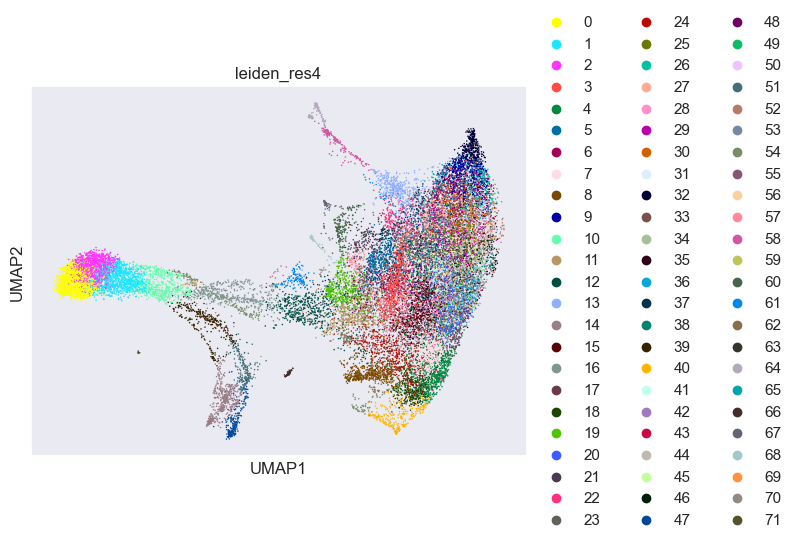

In [67]:
sc.pl.umap(adata, color=["leiden_res4"])

In [ ]:
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_res0.5")
sc.tl.leiden(adata, resolution=1, key_added="leiden_res1")
sc.tl.leiden(adata, resolution=4, key_added="leiden_res4")


/opt/homebrew/Caskroom/miniconda/base/envs/geneformer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


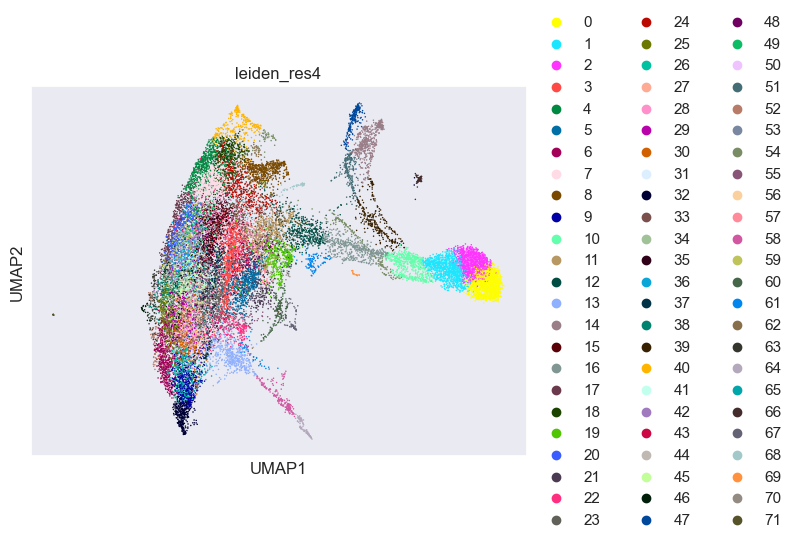

In [58]:
sc.tl.leiden(adata, resolution=4, key_added="leiden_res4")

sc.pl.umap(adata, color=["leiden_res4"])

/opt/homebrew/Caskroom/miniconda/base/envs/geneformer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


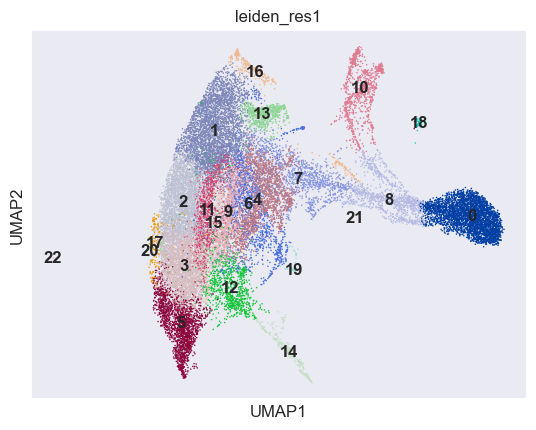

In [60]:
sc.pl.umap(adata, color=["leiden_res1"], legend_loc="on data")

In [ ]:
# l1 C18 are ribo proteins
# l1 C0 are random, unknown, novel, olfactory, proteins
# l1 C14 are signaling proteins, sperm related, 

In [62]:
adata[adata.obs["leiden_res1"]=="14"].obs.head(20)

,leiden_res3,leiden_res1,leiden_res4
ENSG00000042813,9,14,58
ENSG00000065371,9,14,64
ENSG00000069206,9,14,58
ENSG00000075886,9,14,58
ENSG00000079393,9,14,58
ENSG00000101435,9,14,58
ENSG00000102055,9,14,58
ENSG00000104901,9,14,58
ENSG00000105428,9,14,64
ENSG00000105549,9,14,58


In [68]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(25426, 512, padding_idx=0)
    (position_embeddings): Embedding(2048, 512)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.02, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.02, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.02, inplace=False

In [70]:
from key_funcs import *

In [145]:
data = pd.read_csv("../../GroundTruth/scRNA/chen_rna_filtered_log2.tsv", sep="\t")

In [146]:
data.sum(1)

A2M           7.584963
A2ML1-AS1     8.000000
AAAS          7.370143
AACS          8.000000
AADAT         8.000000
               ...    
ZWINT        23.370143
ZXDC         15.000000
ZYG11B        4.000000
ZZEF1         6.000000
ZZZ3          8.370143
Length: 8595, dtype: float64

In [ ]:
data.shape

(8595, 385)

In [156]:
((data>0) & (data<1)).sum().sum(), (data>0).sum().sum() / (data.shape[0]*data.shape[1])

(0, 0.05400935306694469)

: 

In [ ]:
# it is roughly ordered by number of genes expressed
# it is log2p1 transformed

In [142]:
data2 = pd.read_csv("../../GroundTruth/scRNA/liu_rna_filtered_log2.tsv", sep="\t")

In [149]:
data2.shape, data2.sum(1)

((23153, 72),
 A1BG           35.309382
 A1BG-AS1       35.243997
 A1CF            5.995396
 A2M             4.037286
 A2ML1          75.680123
                  ...    
 LINC01422      58.125577
 LINC01481      73.809064
 LINC01505      12.102164
 RAET1E-AS1    129.692229
 RF00017       109.358443
 Length: 23153, dtype: float64)

In [155]:
((data2>0) & (data2<1)).sum().sum(), (data2>0).sum().sum() / (data2.shape[0]*data2.shape[1])

(0, 0.41823353825038273)

In [ ]:
# it is not scRNAseq data
# it is log2p1 transformed

In [81]:
from geneformer import tokenizer

In [82]:
tokener = tokenizer.TranscriptomeTokenizer()

In [ ]:
tokener

In [ ]:
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

In [ ]:
evalset_len = 200 #dataset size



if len(evalset) - max_divisible == 1:
    evalset_len = max_divisible
    

        max_range = min(i+forward_batch_size, evalset_len)
        batch_evalset = evalset.select([i for i in range(i, max_range)])
        padded_batch = preprocess_classifier_batch(batch_evalset, max_evalset_len)
        padded_batch.set_format(type="torch")

In [69]:
input_data_batch = padded_batch["input_ids"]
attn_msk_batch = padded_batch["attention_mask"]
label_batch = padded_batch["labels"]
with torch.no_grad():
    outputs = model(
        input_ids = input_data_batch.to("cpu"), 
        attention_mask = attn_msk_batch.to("cpu"), 
        labels = label_batch.to("cpu"), 
    )

NameError: name 'padded_batch' is not defined

In [ ]:
predict_logits += [torch.squeeze(outputs.logits.to("cpu"))]
predict_labels += [torch.squeeze(label_batch.to("cpu"))]

In [8]:
# preparing targets and labels for dosage sensitive vs insensitive TFs
dosage_tfs = pd.read_csv("../dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()
targets, labels, nsplits = prep_inputs(sensitive, insensitive, "ensembl_id")

# targets1: 122
# targets2: 368
# splits: 5


In [9]:
# load training dataset
train_dataset=load_from_disk("../../Genecorpus-30M/example_input_files/gene_classification/bivalent_promoters/panglao_SRA553822-SRS2119548.dataset")
shuffled_train_dataset = train_dataset.shuffle(seed=42)
subsampled_train_dataset = shuffled_train_dataset.select([i for i in range(30_000)])

## Define Functions for Training and Cross-Validating Classifier

In [10]:
def preprocess_classifier_batch(cell_batch, max_len):
    if max_len == None:
        max_len = max([len(i) for i in cell_batch["input_ids"]])
    def pad_label_example(example):
        example["labels"] = np.pad(example["labels"], 
                                   (0, max_len-len(example["input_ids"])), 
                                   mode='constant', constant_values=-100)
        example["input_ids"] = np.pad(example["input_ids"], 
                                      (0, max_len-len(example["input_ids"])), 
                                      mode='constant', constant_values=token_dictionary.get("<pad>"))
        example["attention_mask"] = (example["input_ids"] != token_dictionary.get("<pad>")).astype(int)
        return example
    padded_batch = cell_batch.map(pad_label_example)
    return padded_batch

# forward batch size is batch size for model inference (e.g. 200)
def classifier_predict(model, evalset, forward_batch_size, mean_fpr):
    predict_logits = []
    predict_labels = []
    model.eval()
    
    # ensure there is at least 2 examples in each batch to avoid incorrect tensor dims
    evalset_len = len(evalset)
    max_divisible = find_largest_div(evalset_len, forward_batch_size)
    if len(evalset) - max_divisible == 1:
        evalset_len = max_divisible
    
    max_evalset_len = max(evalset.select([i for i in range(evalset_len)])["length"])
    
    for i in range(0, evalset_len, forward_batch_size):
        max_range = min(i+forward_batch_size, evalset_len)
        batch_evalset = evalset.select([i for i in range(i, max_range)])
        padded_batch = preprocess_classifier_batch(batch_evalset, max_evalset_len)
        padded_batch.set_format(type="torch")
        
        input_data_batch = padded_batch["input_ids"]
        attn_msk_batch = padded_batch["attention_mask"]
        label_batch = padded_batch["labels"]
        with torch.no_grad():
            outputs = model(
                input_ids = input_data_batch.to("cpu"), 
                attention_mask = attn_msk_batch.to("cpu"), 
                labels = label_batch.to("cpu"), 
            )
            predict_logits += [torch.squeeze(outputs.logits.to("cpu"))]
            predict_labels += [torch.squeeze(label_batch.to("cpu"))]
            
    logits_by_cell = torch.cat(predict_logits)
    all_logits = logits_by_cell.reshape(-1, logits_by_cell.shape[2])
    labels_by_cell = torch.cat(predict_labels)
    all_labels = torch.flatten(labels_by_cell)
    logit_label_paired = [item for item in list(zip(all_logits.tolist(), all_labels.tolist())) if item[1]!=-100]
    y_pred = [vote(item[0]) for item in logit_label_paired]
    y_true = [item[1] for item in logit_label_paired]
    logits_list = [item[0] for item in logit_label_paired]
    # probability of class 1
    y_score = [py_softmax(item)[1] for item in logits_list]
    conf_mat = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    # plot roc_curve for this split
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()
    # interpolate to graph
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return fpr, tpr, interp_tpr, conf_mat 

def vote(logit_pair):
    a, b = logit_pair
    if a > b:
        return 0
    elif b > a:
        return 1
    elif a == b:
        return "tie"
    
def py_softmax(vector):
	e = np.exp(vector)
	return e / e.sum()
    
# get cross-validated mean and sd metrics
def get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt):
    wts = [count/sum(all_tpr_wt) for count in all_tpr_wt]
    print(wts)
    all_weighted_tpr = [a*b for a,b in zip(all_tpr, wts)]
    mean_tpr = np.sum(all_weighted_tpr, axis=0)
    mean_tpr[-1] = 1.0
    all_weighted_roc_auc = [a*b for a,b in zip(all_roc_auc, wts)]
    roc_auc = np.sum(all_weighted_roc_auc)
    roc_auc_sd = math.sqrt(np.average((all_roc_auc-roc_auc)**2, weights=wts))
    return mean_tpr, roc_auc, roc_auc_sd

# Function to find the largest number smaller
# than or equal to N that is divisible by k
def find_largest_div(N, K):
    rem = N % K
    if(rem == 0):
        return N
    else:
        return N - rem

In [11]:
# cross-validate gene classifier
def cross_validate(data, targets, labels, nsplits, subsample_size, training_args, freeze_layers, output_dir, num_proc):
    # check if output directory already written to
    # ensure not overwriting previously saved model
    model_dir_test = os.path.join(output_dir, "ksplit0/models/pytorch_model.bin")
    if os.path.isfile(model_dir_test) == True:
        raise Exception("Model already saved to this directory.")
    
    # initiate eval metrics to return
    num_classes = len(set(labels))
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    all_roc_auc = []
    all_tpr_wt = []
    label_dicts = []
    confusion = np.zeros((num_classes,num_classes))
    
    # set up cross-validation splits
    skf = StratifiedKFold(n_splits=nsplits, random_state=0, shuffle=True)
    # train and evaluate
    iteration_num = 0
    for train_index, eval_index in tqdm(skf.split(targets, labels)):
        if len(labels) > 500:
            print("early stopping activated due to large # of training examples")
            nsplits = 3
            if iteration_num == 3:
                break
        print(f"****** Crossval split: {iteration_num}/{nsplits-1} ******\n")
        # generate cross-validation splits
        targets_train, targets_eval = targets[train_index], targets[eval_index]
        labels_train, labels_eval = labels[train_index], labels[eval_index]
        label_dict_train = dict(zip(targets_train, labels_train))
        label_dict_eval = dict(zip(targets_eval, labels_eval))
        label_dicts += (iteration_num, targets_train, targets_eval, labels_train, labels_eval)
        
        # function to filter by whether contains train or eval labels
        def if_contains_train_label(example):
            a = label_dict_train.keys()
            b = example['input_ids']
            return not set(a).isdisjoint(b)

        def if_contains_eval_label(example):
            a = label_dict_eval.keys()
            b = example['input_ids']
            return not set(a).isdisjoint(b)
        
        # filter dataset for examples containing classes for this split
        print(f"Filtering training data")
        trainset = data.filter(if_contains_train_label, num_proc=num_proc)
        print(f"Filtered {round((1-len(trainset)/len(data))*100)}%; {len(trainset)} remain\n")
        print(f"Filtering evalation data")
        evalset = data.filter(if_contains_eval_label, num_proc=num_proc)
        print(f"Filtered {round((1-len(evalset)/len(data))*100)}%; {len(evalset)} remain\n")

        # minimize to smaller training sample
        training_size = min(subsample_size, len(trainset))
        trainset_min = trainset.select([i for i in range(training_size)])
        eval_size = min(training_size, len(evalset))
        half_training_size = round(eval_size/2)
        evalset_train_min = evalset.select([i for i in range(half_training_size)])
        evalset_oos_min = evalset.select([i for i in range(half_training_size, eval_size)])
        
        # label conversion functions
        def generate_train_labels(example):
            example["labels"] = [label_dict_train.get(token_id, -100) for token_id in example["input_ids"]]
            return example

        def generate_eval_labels(example):
            example["labels"] = [label_dict_eval.get(token_id, -100) for token_id in example["input_ids"]]
            return example
        
        # label datasets 
        print(f"Labeling training data")
        trainset_labeled = trainset_min.map(generate_train_labels)
        print(f"Labeling evaluation data")
        evalset_train_labeled = evalset_train_min.map(generate_eval_labels)
        print(f"Labeling evaluation OOS data")
        evalset_oos_labeled = evalset_oos_min.map(generate_eval_labels)
        
        # create output directories
        ksplit_output_dir = os.path.join(output_dir, f"ksplit{iteration_num}")
        ksplit_model_dir = os.path.join(ksplit_output_dir, "models/") 
        
        # ensure not overwriting previously saved model
        model_output_file = os.path.join(ksplit_model_dir, "pytorch_model.bin")
        if os.path.isfile(model_output_file) == True:
            raise Exception("Model already saved to this directory.")

        # make training and model output directories
        subprocess.call(f'mkdir {ksplit_output_dir}', shell=True)
        subprocess.call(f'mkdir {ksplit_model_dir}', shell=True)
        
        # load model
        model = BertForTokenClassification.from_pretrained(
            "../geneformer-12L-30M/",
            num_labels=2,
            output_attentions = False,
            output_hidden_states = False
        )
        if freeze_layers is not None:
            modules_to_freeze = model.bert.encoder.layer[:freeze_layers]
            for module in modules_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False
                
        model = model.to(torch.device("cpu"))
        
        # add output directory to training args and initiate
        training_args["output_dir"] = ksplit_output_dir
        training_args_init = TrainingArguments(**training_args)
        
        # create the trainer
        trainer = Trainer(
            model=model,
            args=training_args_init,
            data_collator=DataCollatorForGeneClassification(),
            train_dataset=trainset_labeled,
            eval_dataset=evalset_train_labeled
        )

        # train the gene classifier
        trainer.train()
        
        # save model
        trainer.save_model(ksplit_model_dir)
        
        # evaluate model
        fpr, tpr, interp_tpr, conf_mat = classifier_predict(trainer.model, evalset_oos_labeled, 200, mean_fpr)
        
        # append to tpr and roc lists
        confusion = confusion + conf_mat
        all_tpr.append(interp_tpr)
        all_roc_auc.append(auc(fpr, tpr))
        # append number of eval examples by which to weight tpr in averaged graphs
        all_tpr_wt.append(len(tpr))
        
        iteration_num = iteration_num + 1
        
    # get overall metrics for cross-validation
    mean_tpr, roc_auc, roc_auc_sd = get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt)
    return all_roc_auc, roc_auc, roc_auc_sd, mean_fpr, mean_tpr, confusion, label_dicts

## Define Functions for Plotting Results

In [12]:
# plot ROC curve
def plot_ROC(bundled_data, title):
    plt.figure()
    lw = 2
    for roc_auc, roc_auc_sd, mean_fpr, mean_tpr, sample, color in bundled_data:
        plt.plot(mean_fpr, mean_tpr, color=color,
                 lw=lw, label="{0} (AUC {1:0.2f} $\pm$ {2:0.2f})".format(sample, roc_auc, roc_auc_sd))
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
# plot confusion matrix
def plot_confusion_matrix(classes_list, conf_mat, title):
    display_labels = []
    i = 0
    for label in classes_list:
        display_labels += ["{0}\nn={1:.0f}".format(label, sum(conf_mat[:,i]))]
        i = i + 1
    display = ConfusionMatrixDisplay(confusion_matrix=preprocessing.normalize(conf_mat, norm="l1"), 
                                     display_labels=display_labels)
    display.plot(cmap="Blues",values_format=".2g")
    plt.title(title)

## Fine-Tune With Gene Classification Learning Objective and Quantify Predictive Performance

### Please note that, as usual with deep learning models, we **highly** recommend tuning learning hyperparameters for all fine-tuning applications as this can significantly improve model performance. Example hyperparameters are defined below, but please see the "hyperparam_optimiz_for_disease_classifier" script for an example of how to tune hyperparameters for downstream applications.

In [13]:
# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048

# set training hyperparameters
# max learning rate
max_lr = 5e-5
# how many pretrained layers to freeze
freeze_layers = 4
# number gpus
num_gpus = 1
# number cpu cores
num_proc = 24
# batch size for training and eval
geneformer_batch_size = 12
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 500
# number of epochs
epochs = 1
# optimizer
optimizer = "adamw"

In [14]:
# set training arguments
subsample_size = 10_000
training_args = {
    "learning_rate": max_lr,
    "do_train": True,
    "evaluation_strategy": "no",
    "save_strategy": "epoch",
    "logging_steps": 100,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    #'device': "cpu",
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": epochs,
}

In [15]:
# define output directory path
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
training_output_dir = f"../{datestamp}_geneformer_GeneClassifier_dosageTF_L{max_input_size}_B{geneformer_batch_size}_LR{max_lr}_LS{lr_schedule_fn}_WU{warmup_steps}_E{epochs}_O{optimizer}_n{subsample_size}_F{freeze_layers}/"

# ensure not overwriting previously saved model
ksplit_model_test = os.path.join(training_output_dir, "ksplit0/models/pytorch_model.bin")
if os.path.isfile(ksplit_model_test) == True:
    raise Exception("Model already saved to this directory.")

# make output directory
subprocess.call(f'mkdir {training_output_dir}', shell=True)

mkdir: 

1

../231010_geneformer_GeneClassifier_dosageTF_L2048_B12_LR5e-05_LSlinear_WU500_E1_Oadamw_n10000_F4/: File exists


In [16]:
# cross-validate gene classifier
all_roc_auc, roc_auc, roc_auc_sd, mean_fpr, mean_tpr, confusion, label_dicts \
    = cross_validate(subsampled_train_dataset, targets, labels, nsplits, subsample_size, training_args, freeze_layers, training_output_dir, 1)

0it [00:00, ?it/s]

****** Crossval split: 0/4 ******

Filtering training data
Filtered 50%; 14897 remain

Filtering evalation data
Filtered 74%; 7860 remain

Labeling training data
Labeling evaluation data
Labeling evaluation OOS data


mkdir: ../231010_geneformer_GeneClassifier_dosageTF_L2048_B12_LR5e-05_LSlinear_WU500_E1_Oadamw_n10000_F4/ksplit0: File exists
mkdir: ../231010_geneformer_GeneClassifier_dosageTF_L2048_B12_LR5e-05_LSlinear_WU500_E1_Oadamw_n10000_F4/ksplit0/models/: File exists
Some weights of BertForTokenClassification were not initialized from the model checkpoint at ../geneformer-12L-30M/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jkobject (ml4ig). Use `wandb login --relogin` to force relogin


  0%|          | 0/834 [00:00<?, ?it/s]

/Users/jkobject/Documents/code/Geneformer/examples/../geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


RuntimeError: MPS backend out of memory (MPS allocated: 16.74 GB, other allocations: 1.37 GB, max allowed: 18.13 GB). Tried to allocate 637.12 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [17]:
print(torch.cuda.is_available())

False


In [ ]:
# bundle data for plotting
bundled_data = []
bundled_data += [(roc_auc, roc_auc_sd, mean_fpr, mean_tpr, "Geneformer", "red")]

In [ ]:
# plot ROC curve
plot_ROC(bundled_data, 'Dosage Sensitive vs Insensitive TFs')

In [ ]:
# plot confusion matrix
classes_list = ["Dosage Sensitive", "Dosage Insensitive"]
plot_confusion_matrix(classes_list, confusion, "Geneformer")